# Task 1 Start 

### Start the Spark Context

In [1]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "MQTT Dataset"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

C:\Spark\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Read in the datasets and merge. Added a Original_Dataset column to distinguish data.  

#### Note: Using the reduced dataset.

### Defining the column names ourselves so we can clean out periods and anything else we want.

In [2]:
col_names = ['tcp_flags','tcp_time_delta','tcp_len','mqtt_conack_flags','mqtt_conack_flags_reserved',
             'mqtt_conack_flags_sp','mqtt_conack_val','mqtt_conflag_cleansess','mqtt_conflag_passwd',
             'mqtt_conflag_qos','mqtt_conflag_reserved','mqtt_conflag_retain','mqtt_conflag_uname',
             'mqtt_conflag_willflag','mqtt_conflags','mqtt_dupflag','mqtt_hdrflags','mqtt_kalive',
             'mqtt_len','mqtt_msg','mqtt_msgid','mqtt_msgtype','mqtt_proto_len','mqtt_protoname',
             'mqtt_qos','mqtt_retain','mqtt_sub_qos','mqtt_suback_qos','mqtt_ver','mqtt_willmsg',
             'mqtt_willmsg_len','mqtt_willtopic','mqtt_willtopic_len','target']





In [4]:
from pyspark.sql.functions import lit

# Read the first dataset and add a constant column with label "test"
df_train = spark.read.csv("data/train70_reduced.csv", header=True, inferSchema=True).toDF(*col_names)
df_train = df_train.withColumn("Original_Dataset", lit("train"))

# Read the second dataset and add a constant column with label "train"
df_test = spark.read.csv("data/test30_reduced.csv", header=True, inferSchema=True).toDF(*col_names)
df_test = df_test.withColumn("Original_Dataset", lit("test"))


merged_df = df_train.union(df_test)
merged_df.show(1, vertical=True)

23/10/26 23:35:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0------------------------------------------
 tcp_flags                  | 0x00000018           
 tcp_time_delta             | 0.998867             
 tcp_len                    | 10                   
 mqtt_conack_flags          | 0                    
 mqtt_conack_flags_reserved | 0.0                  
 mqtt_conack_flags_sp       | 0.0                  
 mqtt_conack_val            | 0.0                  
 mqtt_conflag_cleansess     | 0.0                  
 mqtt_conflag_passwd        | 0.0                  
 mqtt_conflag_qos           | 0.0                  
 mqtt_conflag_reserved      | 0.0                  
 mqtt_conflag_retain        | 0.0                  
 mqtt_conflag_uname         | 0.0                  
 mqtt_conflag_willflag      | 0.0                  
 mqtt_conflags              | 0                    
 mqtt_dupflag               | 0.0                  
 mqtt_hdrflags              | 0x00000030           
 mqtt_kalive                | 0.0                  
 mqtt_len   

In [5]:
merged_df.groupby("Original_Dataset").count().show()

+----------------+------+
|Original_Dataset| count|
+----------------+------+
|           train|231646|
|            test| 99290|
+----------------+------+



### Creat table on Postgress in Schema with the name "mqtt"
#### Note: Change Postgres password to your own on system password to run.

In [7]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']=""
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "mqtt"


merged_df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

In [8]:
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(1, vertical=True)

-RECORD 0--------------------------------
 tcp_flags                  | 0x00000018 
 tcp_time_delta             | 0.998867   
 tcp_len                    | 10         
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 0.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0          
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0x00000030 
 mqtt_kalive                | 0.0        
 mqtt_len                   | 8.0        
 mqtt_msg                   | 32         
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 3.0        
 mqtt_proto_len             | 0.0 


[Stage 9:>                                                          (0 + 1) / 1]



# Task II Start 

# Part II Question 1
### What is the average length of an MQTT message captured in the training dataset?

In [9]:
df_read.dtypes

[('tcp_flags', 'string'),
 ('tcp_time_delta', 'double'),
 ('tcp_len', 'int'),
 ('mqtt_conack_flags', 'string'),
 ('mqtt_conack_flags_reserved', 'double'),
 ('mqtt_conack_flags_sp', 'double'),
 ('mqtt_conack_val', 'double'),
 ('mqtt_conflag_cleansess', 'double'),
 ('mqtt_conflag_passwd', 'double'),
 ('mqtt_conflag_qos', 'double'),
 ('mqtt_conflag_reserved', 'double'),
 ('mqtt_conflag_retain', 'double'),
 ('mqtt_conflag_uname', 'double'),
 ('mqtt_conflag_willflag', 'double'),
 ('mqtt_conflags', 'string'),
 ('mqtt_dupflag', 'double'),
 ('mqtt_hdrflags', 'string'),
 ('mqtt_kalive', 'double'),
 ('mqtt_len', 'double'),
 ('mqtt_msg', 'string'),
 ('mqtt_msgid', 'double'),
 ('mqtt_msgtype', 'double'),
 ('mqtt_proto_len', 'double'),
 ('mqtt_protoname', 'string'),
 ('mqtt_qos', 'double'),
 ('mqtt_retain', 'double'),
 ('mqtt_sub_qos', 'double'),
 ('mqtt_suback_qos', 'double'),
 ('mqtt_ver', 'double'),
 ('mqtt_willmsg', 'double'),
 ('mqtt_willmsg_len', 'double'),
 ('mqtt_willtopic', 'double'),
 ('m

In [10]:
from pyspark.sql.functions import col
train_data = df_read.where(col('Original_Dataset') == 'train')
mean_mqtt_len_train = train_data.select(col('mqtt_len')).summary('mean')
mean_mqtt_len_train.show()

+-------+------------------+
|summary|          mqtt_len|
+-------+------------------+
|   mean|31.435725201384873|
+-------+------------------+



# Part II Answer 1: The average length of mqtt messages in the train dataset is ~31.436

# Part II Question 2
### For each target value, what is the average length of the TCP message? (Conduct this process programmatically and don’t hardcode any of the target values in your command)

In [11]:
df_read.select('target').distinct().show()

+----------+
|    target|
+----------+
|   slowite|
|bruteforce|
|     flood|
| malformed|
|       dos|
|legitimate|
+----------+



In [12]:
from pyspark.sql.functions import avg
avg_mqtt_len_by_target = df_read.groupBy('target').agg(avg('mqtt_len'))
avg_mqtt_len_by_target.show()


+----------+------------------+
|    target|     avg(mqtt_len)|
+----------+------------------+
|   slowite|3.5331449684851117|
|bruteforce|2.9956554720364115|
|     flood| 7.491027732463295|
| malformed| 6.263181984621018|
|       dos| 71.13934256294488|
|legitimate| 6.515196750935254|
+----------+------------------+



# Part II Answer 2: The average length of mqtt messages for each target value are as follows:

1. slowite = 3.5331449684851117
2. bruteforce = 2.9956554720364115
3. flood = 7.491027732463295
4. malformed = 6.263181984621018
5. dos = 71.13934256294488
6. legitimate = 6.515196750935254


# Part II Question 3
### Build a Python function that uses PySpark to list the most frequent X TCP flags where X is a user-provided parameter.
#### Make sure to handle this scenario as well: if the user requests 5 most frequent TCP flags but there are 3 Flags that share the same count at rank number 5, please include all of them in your output

In [13]:
df_read.select('tcp_flags').distinct().show()

+----------+
| tcp_flags|
+----------+
|0x00000004|
|0x00000010|
|0x00000019|
|0x00000002|
|0x00000012|
|0x00000014|
|0x00000018|
|0x00000011|
+----------+



In [14]:
print(type(df_read.select('tcp_flags').distinct().count()))
print(df_read.select('tcp_flags').distinct().count())

<class 'int'>
8


In [15]:
from pyspark.sql.functions import desc
grouped_df = df_read.groupBy('tcp_flags').count().orderBy(desc('count'))
grouped_df.show()

+----------+------+
| tcp_flags| count|
+----------+------+
|0x00000018|183076|
|0x00000010|134547|
|0x00000011|  4198|
|0x00000002|  3372|
|0x00000012|  3372|
|0x00000004|  1592|
|0x00000019|   738|
|0x00000014|    41|
+----------+------+



In [16]:
from pyspark.sql.functions import dense_rank, desc
from pyspark.sql.window import Window

def get_X_most_frequent_tcp_flags(x):
    distinct_flags = df_read.select('tcp_flags').distinct().count()
    if x > distinct_flags:
        print(f"There are only {distinct_flags} distinct TCP flags in this dataset. Showing all {distinct_flags} TCP flags ranked with dense ranking.")
        x = distinct_flags
    window_spec = Window.partitionBy().orderBy(desc('count'))
    ranked_df = grouped_df.withColumn("dense_rank", dense_rank().over(window_spec))
    result = ranked_df.filter(col("dense_rank") <= x)
    result.show()



# Part II Answer 3: The above function uses PySpark to list the x most frequent functions and also includes ties if they occur at the xth entry. Sample output below for x = 4, which is a tie case. 

### NOTE: The warning can be ignored in this case. We do not want to partition the data as we are trying to rank all of the tcp flags against one another with respect to their count. Partitioning would end up comparing each tcp flag type to itslef and thus result in all of them being ranked as 1.  

In [17]:
get_X_most_frequent_tcp_flags(4)

23/10/09 11:32:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/09 11:32:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/09 11:32:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/09 11:32:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/09 11:32:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/09 11:32:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/09 1

+----------+------+----------+
| tcp_flags| count|dense_rank|
+----------+------+----------+
|0x00000018|183076|         1|
|0x00000010|134547|         2|
|0x00000011|  4198|         3|
|0x00000002|  3372|         4|
|0x00000012|  3372|         4|
+----------+------+----------+



23/10/09 11:32:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/09 11:32:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


# Part II Question 4
### Among the listed targets, what is the most popular target on Google News? (Use 5-minutes Google News feed to justify your answer).
1. Use this query: https://news.google.com/rss/search?q=popular+cyber+attacks 
<br>
<br>
2. You may find yourself in need to decrypt the target values in the dataset to proper English equivalent. For example, “bruteforce” to “brute force”.  

In [18]:
df_read.select('target').distinct().show()

+----------+
|    target|
+----------+
|   slowite|
|bruteforce|
|     flood|
| malformed|
|       dos|
|legitimate|
+----------+



### Need to split the following words:
1. bruteforce -> brute force

In [19]:
import numpy as np
print(len(df_read.select('target').collect()))
unique_target_type =[]
for i in range(len(df_read.select('target').distinct().collect())):
    unique_target_type.append(df_read.select('target').distinct().collect()[i][0])

330936


In [20]:
print(unique_target_type)

['slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate']


In [21]:
unique_target_type.append("brute force")

In [22]:
print(unique_target_type)

['slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate', 'brute force']


In [30]:
unique_target_type.append("cyber")

In [31]:
print(unique_target_type)

['slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate', 'brute force', 'cyber']


## Create Consumer and Producer
#### NOTE: Producer is run in a seperate notebook, but the code for it is included here as a comment. 

### Kafka Config

In [23]:
from confluent_kafka import Producer
import socket
#Initialize Your Parameters here - Keep the variable values as is for the ones you can't find on the Confluent-Kafka connection 
KAFKA_CONFIG = {
    "bootstrap.servers":"pkc-lzvrd.us-west4.gcp.confluent.cloud:9092", #Add server it gives you
    "security.protocol":"SASL_SSL",
    "sasl.mechanisms":"PLAIN",
    "sasl.username":"KPCWQU76CLNVNZTT", #Add username given on site
    "sasl.password":"6jL00qPsdQ7PzmXuVhZm+jGtFyLu9vw26a1s8oEPJv93Dlvlk8dvkyKAT0v/1wR9", #Add password given on site
    "session.timeout.ms":"45000",
    "group.id":"python-group-1",    
    'auto.offset.reset': 'smallest',
    'client.id': socket.gethostname()
}

# Update your topic name
topic_name = "topic_0" #Add topic given on site
producer = Producer(KAFKA_CONFIG)
print("done")

done


%4|1696865584.803|CONFWARN|chads-mbp-4.wifi.local.cmu.edu#producer-1| [thrd:app]: Configuration property group.id is a consumer property and will be ignored by this producer instance
%4|1696865584.803|CONFWARN|chads-mbp-4.wifi.local.cmu.edu#producer-1| [thrd:app]: Configuration property session.timeout.ms is a consumer property and will be ignored by this producer instance
%4|1696865584.803|CONFWARN|chads-mbp-4.wifi.local.cmu.edu#producer-1| [thrd:app]: Configuration property auto.offset.reset is a consumer property and will be ignored by this producer instance


### Producer (runs in seperate notebook)

In [24]:
# import feedparser
# import time
# start_time = time.time()
# # We are searching for Analytics in the news
# feed_url = "https://news.google.com/rss/search?q=popular+cyber+attacks"
# def extract_news_feed(feed_url):
#     feed = feedparser.parse(feed_url)
#     articles = []
#     extracted_articles = set()
#     start_time = time.time()
#     while time.time() < (start_time + 60 * 5):  #Newsfeed for 5 Minutes
#         for entry in feed.entries:
#             link = entry.link
#             title = entry.title.encode('ascii', 'ignore').decode()
#             unique_id = f'{link}-{title}'
#             if unique_id in extracted_articles:
#                 continue
#             extracted_articles.add(unique_id)
#             article_data = {"title": title, "link":link}
#             if article_data is not None:
#                 producer.produce(topic_name, key=article_data["title"], value=article_data["link"])
#         producer.flush()

    
# extract_news_feed(feed_url)

### Consumer

In [28]:
from confluent_kafka import Consumer
from pyspark.sql.types import *
import string


# Clean the punctation by making a translation table that maps punctations to empty strings
translator = str.maketrans("", "", string.punctuation)


emp_RDD = spark.sparkContext.emptyRDD()
# Defining the schema of the DataFrame
columns = StructType([StructField('key', StringType(), False),
                      StructField('value', StringType(), False)])

# Creating an empty DataFrame
df = spark.createDataFrame(data=emp_RDD,
                                   schema=columns)
 
# Printing the DataFrame with no data
df.show()

consumer = Consumer(KAFKA_CONFIG)
consumer.subscribe([topic_name])


try:
    i = 0
    while i < 120:
        msg = consumer.poll(timeout=1.0)
        if msg is None:
            i = i + 1
            print("Waiting...")
            continue
        if msg is not None:
            key = msg.key().decode('utf-8').lower().translate(translator)
            cleaned_key = " ".join(key.split())
            value = msg.value().decode('utf-8')
            added_row = [[cleaned_key,value]]
            added_df = spark.createDataFrame(added_row, columns)
            df = df.union(added_df)

except KeyboardInterrupt:
    pass
finally:
    consumer.close()
    df.show()

+---+-----+
|key|value|
+---+-----+
+---+-----+

Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiti

+--------------------+--------------------+
|                 key|               value|
+--------------------+--------------------+
|gazalinked cyber ...|https://news.goog...|
|healthcare top in...|https://news.goog...|
|cloud attacks top...|https://news.goog...|
|cisos watch out t...|https://news.goog...|
|us healthcare ind...|https://news.goog...|
|isro fights over ...|https://news.goog...|
|germany is failin...|https://news.goog...|
|security analytic...|https://news.goog...|
|canadian organiza...|https://news.goog...|
|rising cyberattac...|https://news.goog...|
|cyber insurers in...|https://news.goog...|
|the top five cybe...|https://news.goog...|
|the biggest cyber...|https://news.goog...|
|aggressive china ...|https://news.goog...|
|cyber security br...|https://news.goog...|
|cybersecurity tre...|https://news.goog...|
|us no major cyber...|https://news.goog...|
|how to stay safe ...|https://news.goog...|
|mgm expects 100 m...|https://news.goog...|
|kaspersky identif...|https://ne


[Stage 87:============================================>           (16 + 1) / 20]



### Search the data for our target words

In [32]:
from pyspark.sql.functions import *


streamed_data = df.withColumn('word', explode(split(col('key'), ' '))) \
                .filter(col('word').isin(unique_target_type)) \
                .groupBy('word') \
                .count() \
                .sort('count', ascending=False)
    
streamed_data.show()

+-----+-----+
| word|count|
+-----+-----+
|cyber|   74|
+-----+-----+




[Stage 89:=======================================================>(98 + 1) / 99]



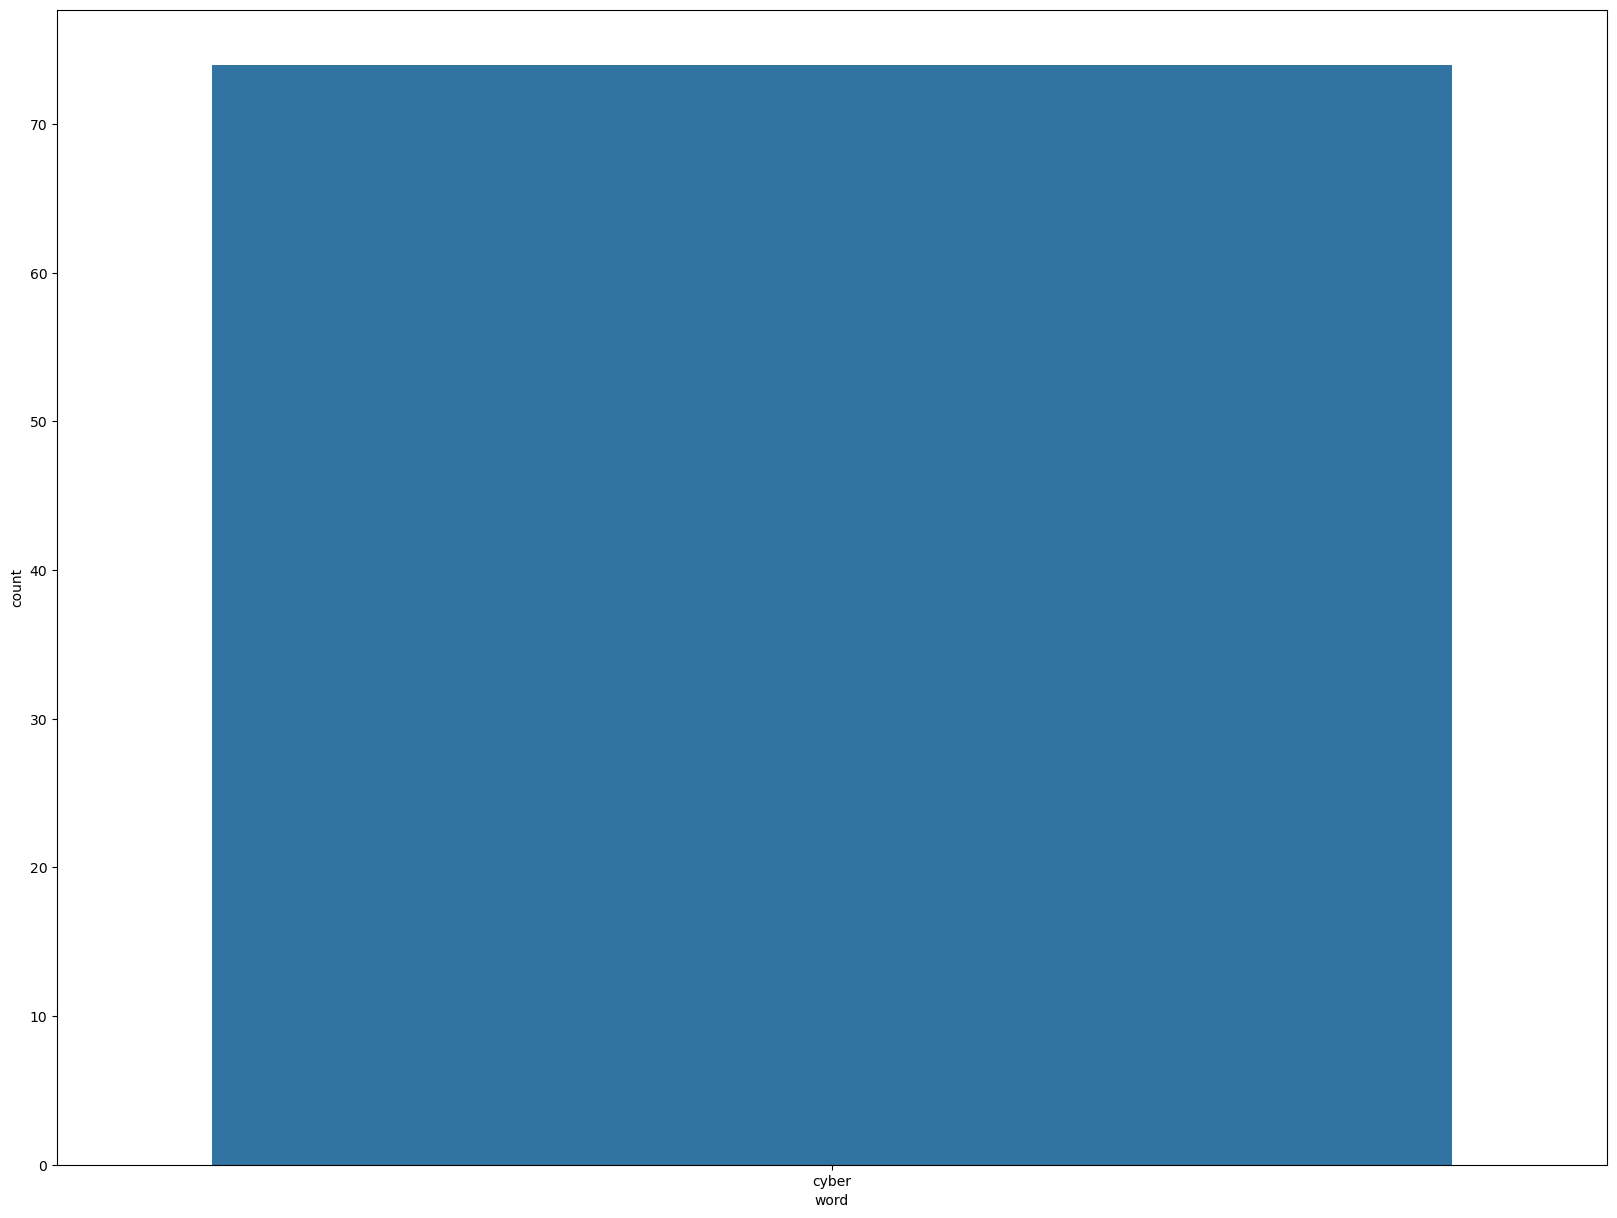

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
protocol_hits = streamed_data.orderBy("count",ascending=False).limit(7).toPandas()
plt.figure( figsize = ( 20, 15 ) )
sns.barplot( x="word", y="count", data=protocol_hits)
plt.show()